# TaniFi DiLoCo Analysis Notebook

This notebook analyzes the results from DiLoCo federated learning simulations for the research paper.

**Paper Title:** Simulation of Bandwidth-Efficient Federated Learning Architectures for Resource-Constrained Agricultural Networks in Indonesia

## Sections:
1. Load and Explore Results
2. Centralized vs Federated Comparison
3. Training Convergence Analysis (Loss, Accuracy, F1)
4. Bandwidth Efficiency Analysis
5. Economic Impact Analysis
6. Generate Paper-Ready Figures & LaTeX Tables

In [28]:
import sys
print(sys.executable)

# Import libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style for paper-quality plots
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

# Configure matplotlib for better quality
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (10, 6)

results_dir = Path('../experiments/results')
plots_dir = results_dir / 'plots'
tables_dir = results_dir / 'tables'
plots_dir.mkdir(parents=True, exist_ok=True)
tables_dir.mkdir(parents=True, exist_ok=True)

print("Libraries loaded successfully")

/home/karel/code/TaniFi/venv/bin/python
Libraries loaded successfully


## 1. Load All Results (Centralized + Federated)

In [29]:
# Load centralized baseline results
baseline_files = sorted(results_dir.glob('centralized_baseline_*.json'))
baseline_data = None
if baseline_files:
    with open(baseline_files[-1], 'r') as f:  # latest baseline
        baseline_data = json.load(f)
    bm = baseline_data['results']['metrics']
    bs = baseline_data['results']['summary']
    bt = baseline_data['results'].get('test_metrics', {})
    print(f"Centralized Baseline loaded: {baseline_files[-1].name}")
    print(f"  Final train loss: {bs['final_loss']:.4f}")
    print(f"  Final val accuracy: {bs.get('final_val_accuracy', 'N/A')}")
    print(f"  Final val F1: {bs.get('final_val_f1', 'N/A')}")
    print(f"  Test accuracy: {bt.get('accuracy', 'N/A')}")
    print(f"  Test F1: {bt.get('f1_macro', 'N/A')}")
else:
    print("No centralized baseline found!")

# Load federated experiment results
fed_files = sorted(results_dir.glob('diloco_*.json'))
print(f"\nFound {len(fed_files)} federated experiment files")

fed_experiments = []
for result_file in fed_files:
    with open(result_file, 'r') as f:
        data = json.load(f)
    
    config = data['configuration']
    metrics = data['results']['metrics']
    summary = data['results']['summary']
    test_metrics = data['results'].get('test_metrics', {})
    
    exp_record = {
        'filename': result_file.name,
        'num_farmers': config['num_farmers'],
        'local_steps': config['local_steps'],
        'num_rounds': len(metrics['rounds']),
        'initial_loss': summary['initial_loss'],
        'final_loss': summary['final_loss'],
        'loss_reduction_pct': summary['loss_reduction_percent'],
        'avg_bandwidth_saved': summary['avg_bandwidth_saved_percent'],
        'final_val_accuracy': summary.get('final_val_accuracy', None),
        'final_val_f1': summary.get('final_val_f1', None),
        'test_accuracy': test_metrics.get('accuracy', None),
        'test_f1': test_metrics.get('f1_macro', None),
        'rounds_data': metrics['rounds'],
        'loss_data': metrics['avg_loss'],
        'bandwidth_data': metrics['bandwidth_saved'],
        'val_accuracy_data': metrics.get('val_accuracy', []),
        'val_f1_data': metrics.get('val_f1_macro', []),
    }
    fed_experiments.append(exp_record)

df = pd.DataFrame(fed_experiments)
df = df.sort_values(['num_farmers', 'local_steps']).reset_index(drop=True)

print(f"\nFederated Experiments Summary:")
display(df[['num_farmers', 'local_steps', 'num_rounds', 'final_loss', 
            'loss_reduction_pct', 'avg_bandwidth_saved', 
            'final_val_accuracy', 'final_val_f1', 
            'test_accuracy', 'test_f1']].round(4))

Centralized Baseline loaded: centralized_baseline_20260210_235551.json
  Final train loss: 1.1212
  Final val accuracy: 0.8076923076923077
  Final val F1: 0.44680851063829785
  Test accuracy: 0.5384615384615384
  Test F1: 0.2333333333333333

Found 2 federated experiment files

Federated Experiments Summary:


,num_farmers,local_steps,num_rounds,final_loss,loss_reduction_pct,avg_bandwidth_saved,final_val_accuracy,final_val_f1,test_accuracy,test_f1
0,10,50,200,1.2260,-4.6132,99.2492,0.8077,0.4468,0.5385,0.2333
1,10,500,20,0.9182,-15.9775,99.2492,0.8077,0.4468,0.5385,0.2333


## 2. Centralized vs Federated Comparison

Centralized vs Best Federated Comparison:


,Metric,Centralized,Best Federated (10f/50s)
0,Train Loss,1.1212,1.2260
1,Val Accuracy,0.8077,0.8077
2,Val F1 (macro),0.4468,0.4468
3,Test Accuracy,0.5385,0.5385
4,Test F1 (macro),0.2333,0.2333
5,Bandwidth Savings (%),0.00 (baseline),99.25


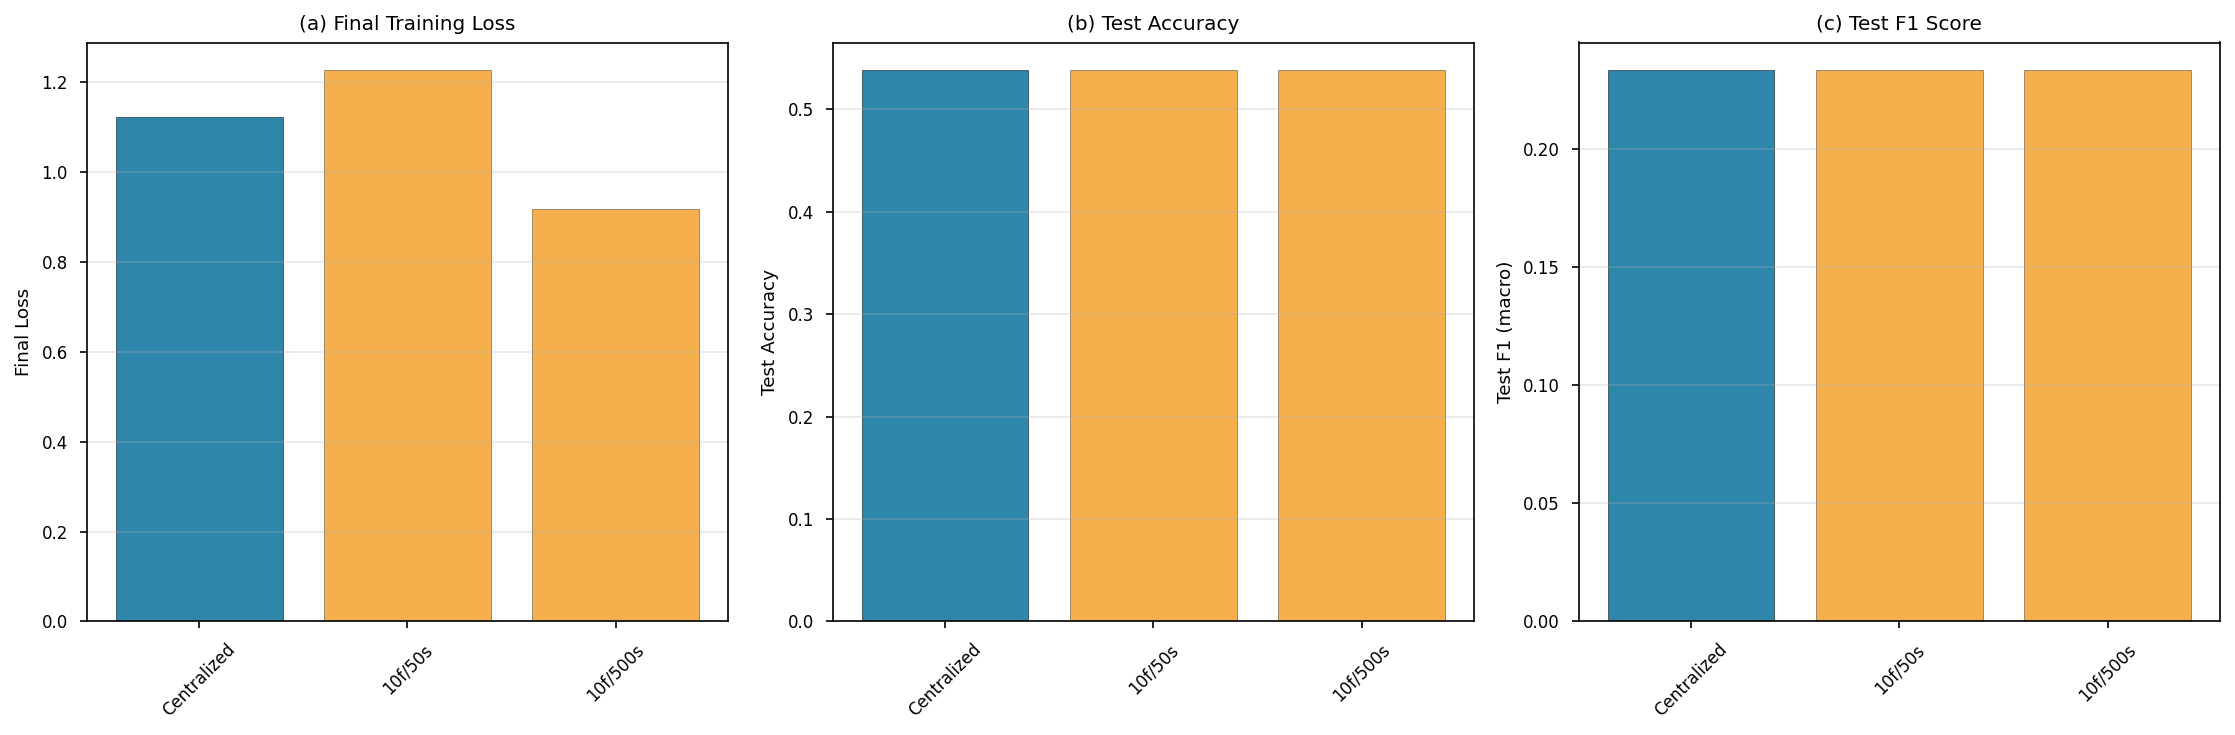

In [30]:
# Centralized vs Federated comparison table
if baseline_data and len(df) > 0:
    bs = baseline_data['results']['summary']
    bt = baseline_data['results'].get('test_metrics', {})
    
    best_fed = df.loc[df['test_f1'].idxmax()] if df['test_f1'].notna().any() else df.iloc[0]
    
    comparison = pd.DataFrame({
        'Metric': ['Train Loss', 'Val Accuracy', 'Val F1 (macro)', 
                   'Test Accuracy', 'Test F1 (macro)', 'Bandwidth Savings (%)'],
        'Centralized': [
            f"{bs['final_loss']:.4f}",
            f"{bs.get('final_val_accuracy', 0):.4f}",
            f"{bs.get('final_val_f1', 0):.4f}",
            f"{bt.get('accuracy', 0):.4f}",
            f"{bt.get('f1_macro', 0):.4f}",
            "0.00 (baseline)"
        ],
        f"Best Federated ({int(best_fed['num_farmers'])}f/{int(best_fed['local_steps'])}s)": [
            f"{best_fed['final_loss']:.4f}",
            f"{best_fed.get('final_val_accuracy', 0):.4f}" if best_fed.get('final_val_accuracy') else "N/A",
            f"{best_fed.get('final_val_f1', 0):.4f}" if best_fed.get('final_val_f1') else "N/A",
            f"{best_fed.get('test_accuracy', 0):.4f}" if best_fed.get('test_accuracy') else "N/A",
            f"{best_fed.get('test_f1', 0):.4f}" if best_fed.get('test_f1') else "N/A",
            f"{best_fed['avg_bandwidth_saved']:.2f}"
        ]
    })
    
    print("Centralized vs Best Federated Comparison:")
    display(comparison)
    
    # Bar chart comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Loss comparison
    ax = axes[0]
    central_loss = bs['final_loss']
    fed_losses = df['final_loss'].values
    ax.bar(['Centralized'], [central_loss], color='#2E86AB', edgecolor='black')
    ax.bar([f'{int(r["num_farmers"])}f/{int(r["local_steps"])}s' for _, r in df.iterrows()], 
           fed_losses, color='#F18F01', edgecolor='black', alpha=0.7)
    ax.set_ylabel('Final Loss')
    ax.set_title('(a) Final Training Loss')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Accuracy comparison
    ax = axes[1]
    central_acc = bt.get('accuracy', 0)
    fed_accs = df['test_accuracy'].fillna(0).values
    ax.bar(['Centralized'], [central_acc], color='#2E86AB', edgecolor='black')
    ax.bar([f'{int(r["num_farmers"])}f/{int(r["local_steps"])}s' for _, r in df.iterrows()], 
           fed_accs, color='#F18F01', edgecolor='black', alpha=0.7)
    ax.set_ylabel('Test Accuracy')
    ax.set_title('(b) Test Accuracy')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # F1 comparison
    ax = axes[2]
    central_f1 = bt.get('f1_macro', 0)
    fed_f1s = df['test_f1'].fillna(0).values
    ax.bar(['Centralized'], [central_f1], color='#2E86AB', edgecolor='black')
    ax.bar([f'{int(r["num_farmers"])}f/{int(r["local_steps"])}s' for _, r in df.iterrows()], 
           fed_f1s, color='#F18F01', edgecolor='black', alpha=0.7)
    ax.set_ylabel('Test F1 (macro)')
    ax.set_title('(c) Test F1 Score')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'centralized_vs_federated.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Need both centralized baseline and federated results for comparison")

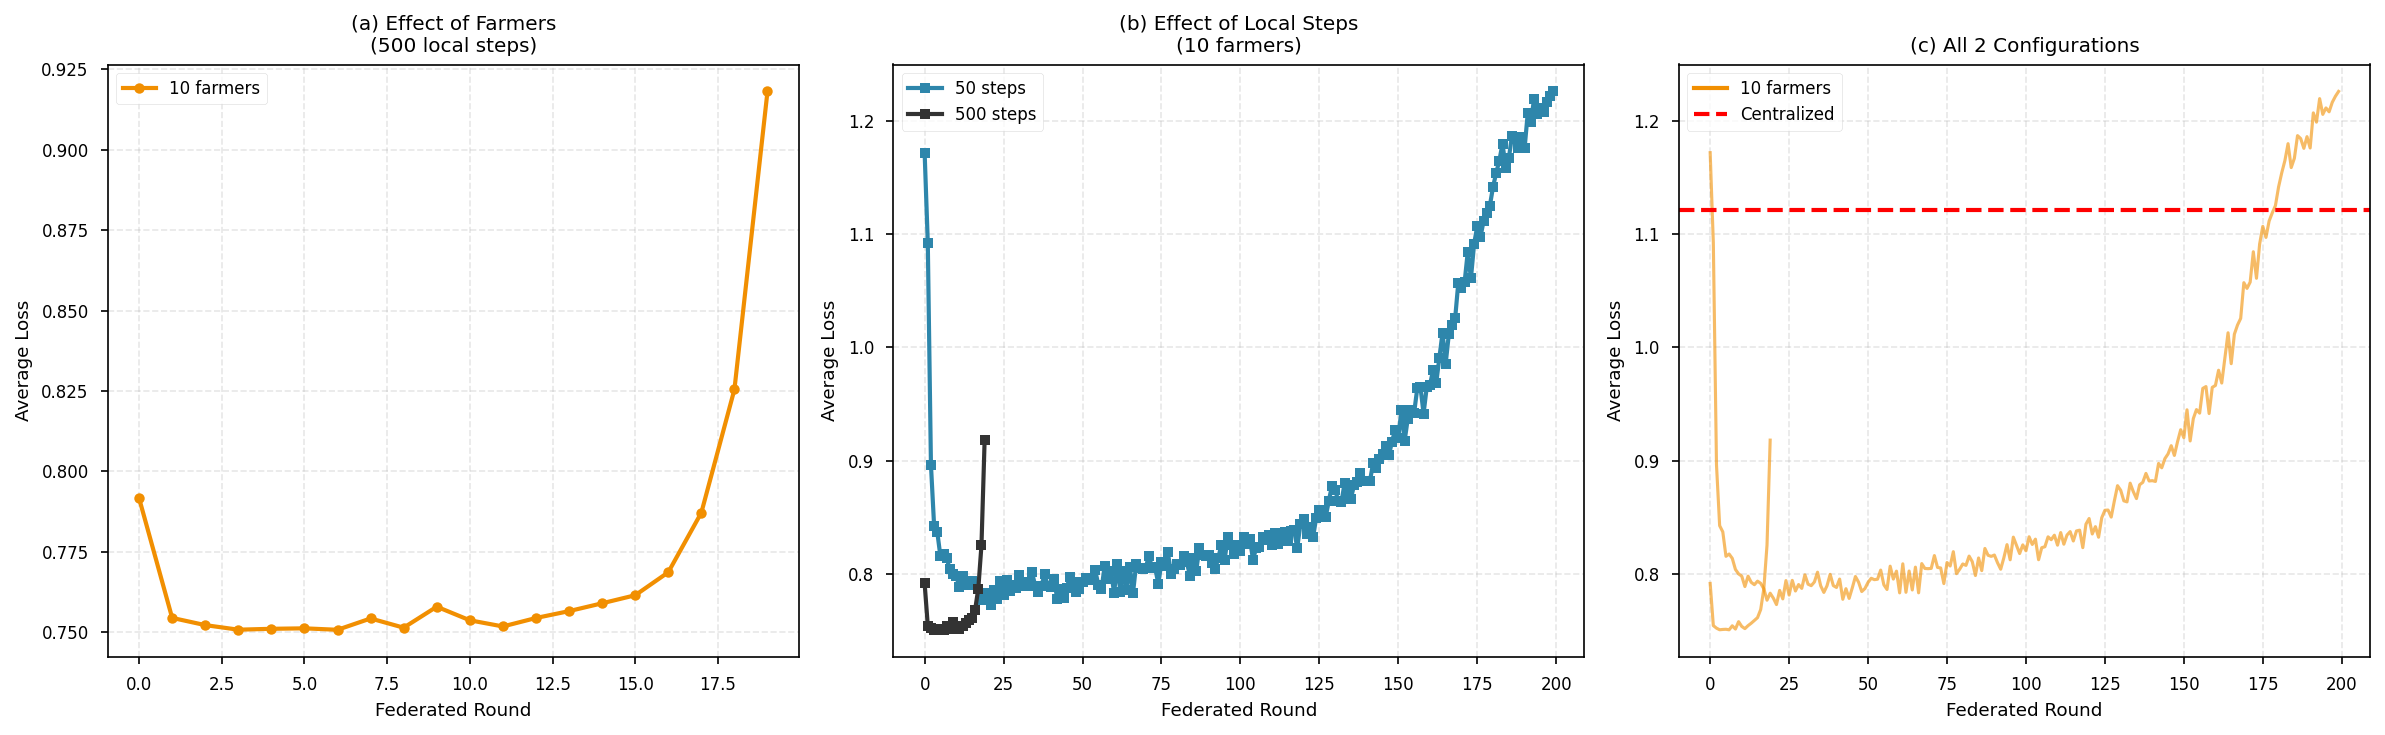

In [31]:
# Training convergence: Loss curves across all configurations
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

farmer_colors = {3: '#2E86AB', 5: '#A23B72', 10: '#F18F01'}

# Plot 1: Effect of farmers (fix steps=25, the middle value)
ax = axes[0]
mid_steps = sorted(df['local_steps'].unique())[len(df['local_steps'].unique())//2] if len(df) > 0 else 25
for farmers in sorted(df['num_farmers'].unique()):
    subset = df[(df['num_farmers'] == farmers) & (df['local_steps'] == mid_steps)]
    if len(subset) > 0:
        row = subset.iloc[0]
        ax.plot(row['rounds_data'], row['loss_data'], 
                marker='o', linewidth=2, markersize=5,
                label=f'{int(farmers)} farmers', color=farmer_colors.get(int(farmers), '#333'))
ax.set_xlabel('Federated Round')
ax.set_ylabel('Average Loss')
ax.set_title(f'(a) Effect of Farmers\n({int(mid_steps)} local steps)')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend()

# Plot 2: Effect of local steps (fix farmers=5, the middle value)
ax = axes[1]
mid_farmers = sorted(df['num_farmers'].unique())[len(df['num_farmers'].unique())//2] if len(df) > 0 else 5
step_colors = {10: '#C73E1D', 25: '#F18F01', 50: '#2E86AB'}
for steps in sorted(df['local_steps'].unique()):
    subset = df[(df['num_farmers'] == mid_farmers) & (df['local_steps'] == steps)]
    if len(subset) > 0:
        row = subset.iloc[0]
        ax.plot(row['rounds_data'], row['loss_data'], 
                marker='s', linewidth=2, markersize=5,
                label=f'{int(steps)} steps', color=step_colors.get(int(steps), '#333'))
ax.set_xlabel('Federated Round')
ax.set_ylabel('Average Loss')
ax.set_title(f'(b) Effect of Local Steps\n({int(mid_farmers)} farmers)')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend()

# Plot 3: All configurations
ax = axes[2]
for _, row in df.iterrows():
    ax.plot(row['rounds_data'], row['loss_data'], 
            linewidth=1.5, alpha=0.6,
            color=farmer_colors.get(int(row['num_farmers']), '#333'))
# Add centralized baseline as horizontal line
if baseline_data:
    ax.axhline(y=bs['final_loss'], color='red', linestyle='--', linewidth=2, label='Centralized')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=farmer_colors[f], linewidth=2, label=f'{f} farmers') 
                   for f in sorted(farmer_colors.keys()) if f in df['num_farmers'].values]
if baseline_data:
    legend_elements.append(Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Centralized'))
ax.legend(handles=legend_elements)
ax.set_xlabel('Federated Round')
ax.set_ylabel('Average Loss')
ax.set_title(f'(c) All {len(df)} Configurations')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(plots_dir / 'convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Accuracy & F1 Convergence

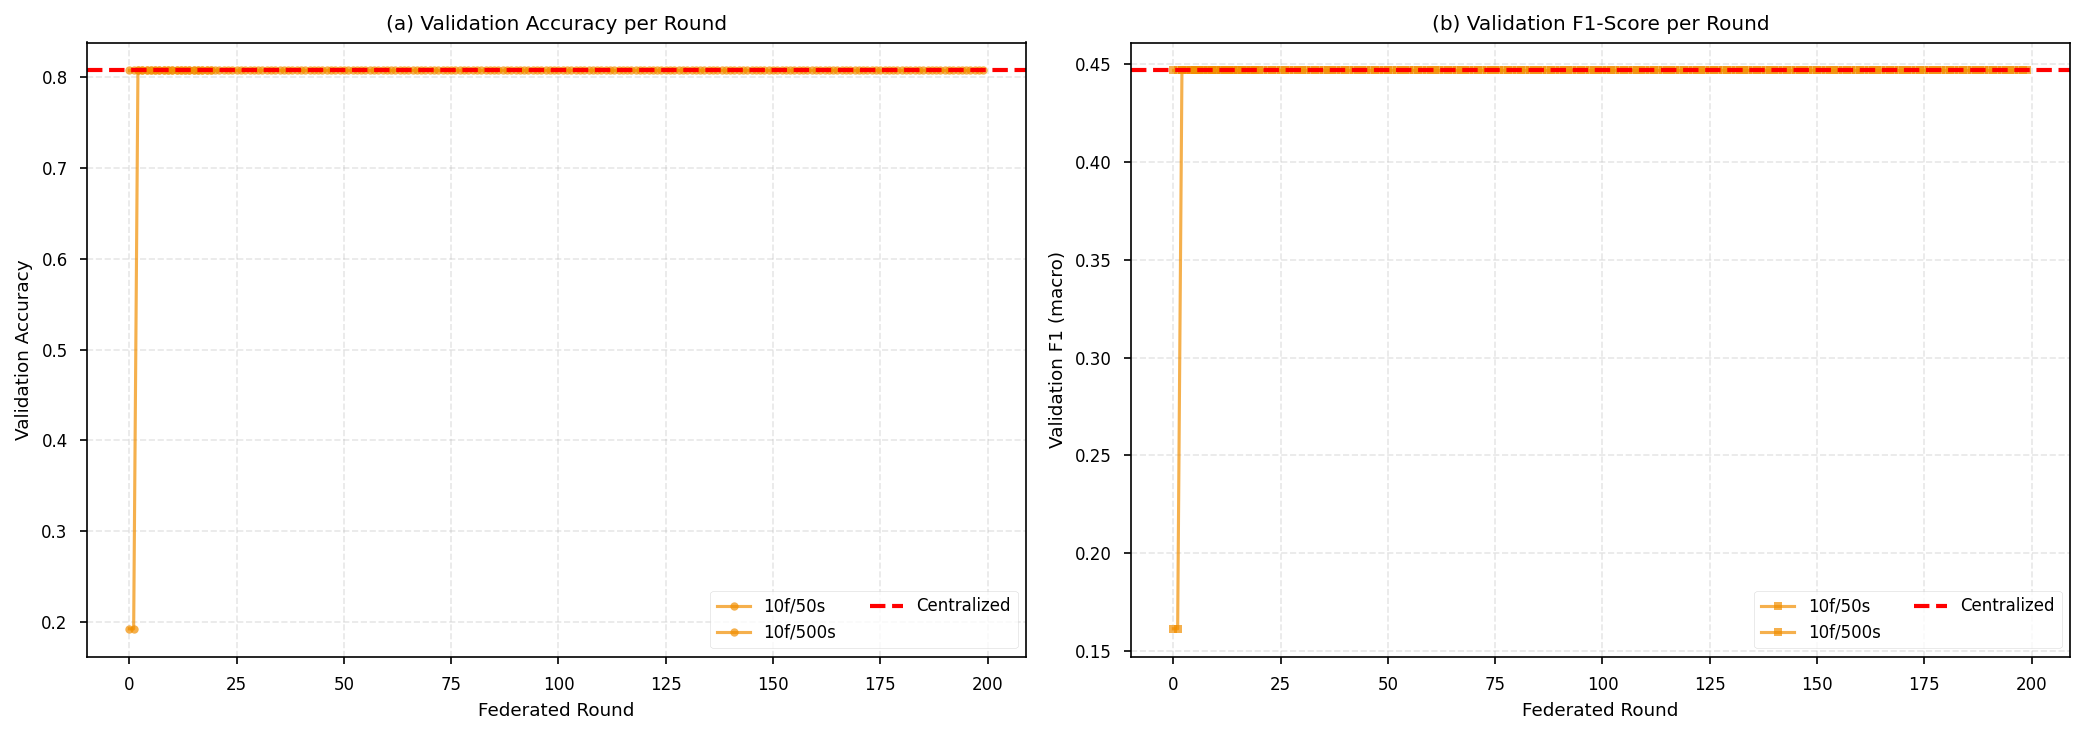

In [32]:
# Accuracy and F1 convergence curves
has_acc = df['val_accuracy_data'].apply(len).sum() > 0

if has_acc:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Val Accuracy over rounds
    ax = axes[0]
    for _, row in df.iterrows():
        if len(row['val_accuracy_data']) > 0:
            label = f"{int(row['num_farmers'])}f/{int(row['local_steps'])}s"
            ax.plot(row['rounds_data'][:len(row['val_accuracy_data'])], 
                    row['val_accuracy_data'], 
                    marker='o', linewidth=1.5, markersize=4, label=label,
                    color=farmer_colors.get(int(row['num_farmers']), '#333'),
                    alpha=0.7)
    if baseline_data and 'val_accuracy' in bm:
        ax.axhline(y=bm['val_accuracy'][-1], color='red', linestyle='--', 
                    linewidth=2, label='Centralized')
    ax.set_xlabel('Federated Round')
    ax.set_ylabel('Validation Accuracy')
    ax.set_title('(a) Validation Accuracy per Round')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=8, ncol=2)
    
    # Val F1 over rounds
    ax = axes[1]
    for _, row in df.iterrows():
        if len(row['val_f1_data']) > 0:
            label = f"{int(row['num_farmers'])}f/{int(row['local_steps'])}s"
            ax.plot(row['rounds_data'][:len(row['val_f1_data'])], 
                    row['val_f1_data'], 
                    marker='s', linewidth=1.5, markersize=4, label=label,
                    color=farmer_colors.get(int(row['num_farmers']), '#333'),
                    alpha=0.7)
    if baseline_data and 'val_f1_macro' in bm:
        ax.axhline(y=bm['val_f1_macro'][-1], color='red', linestyle='--', 
                    linewidth=2, label='Centralized')
    ax.set_xlabel('Federated Round')
    ax.set_ylabel('Validation F1 (macro)')
    ax.set_title('(b) Validation F1-Score per Round')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=8, ncol=2)
    
    plt.tight_layout()
    plt.savefig(plots_dir / 'accuracy_f1_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No accuracy/F1 data available in results")

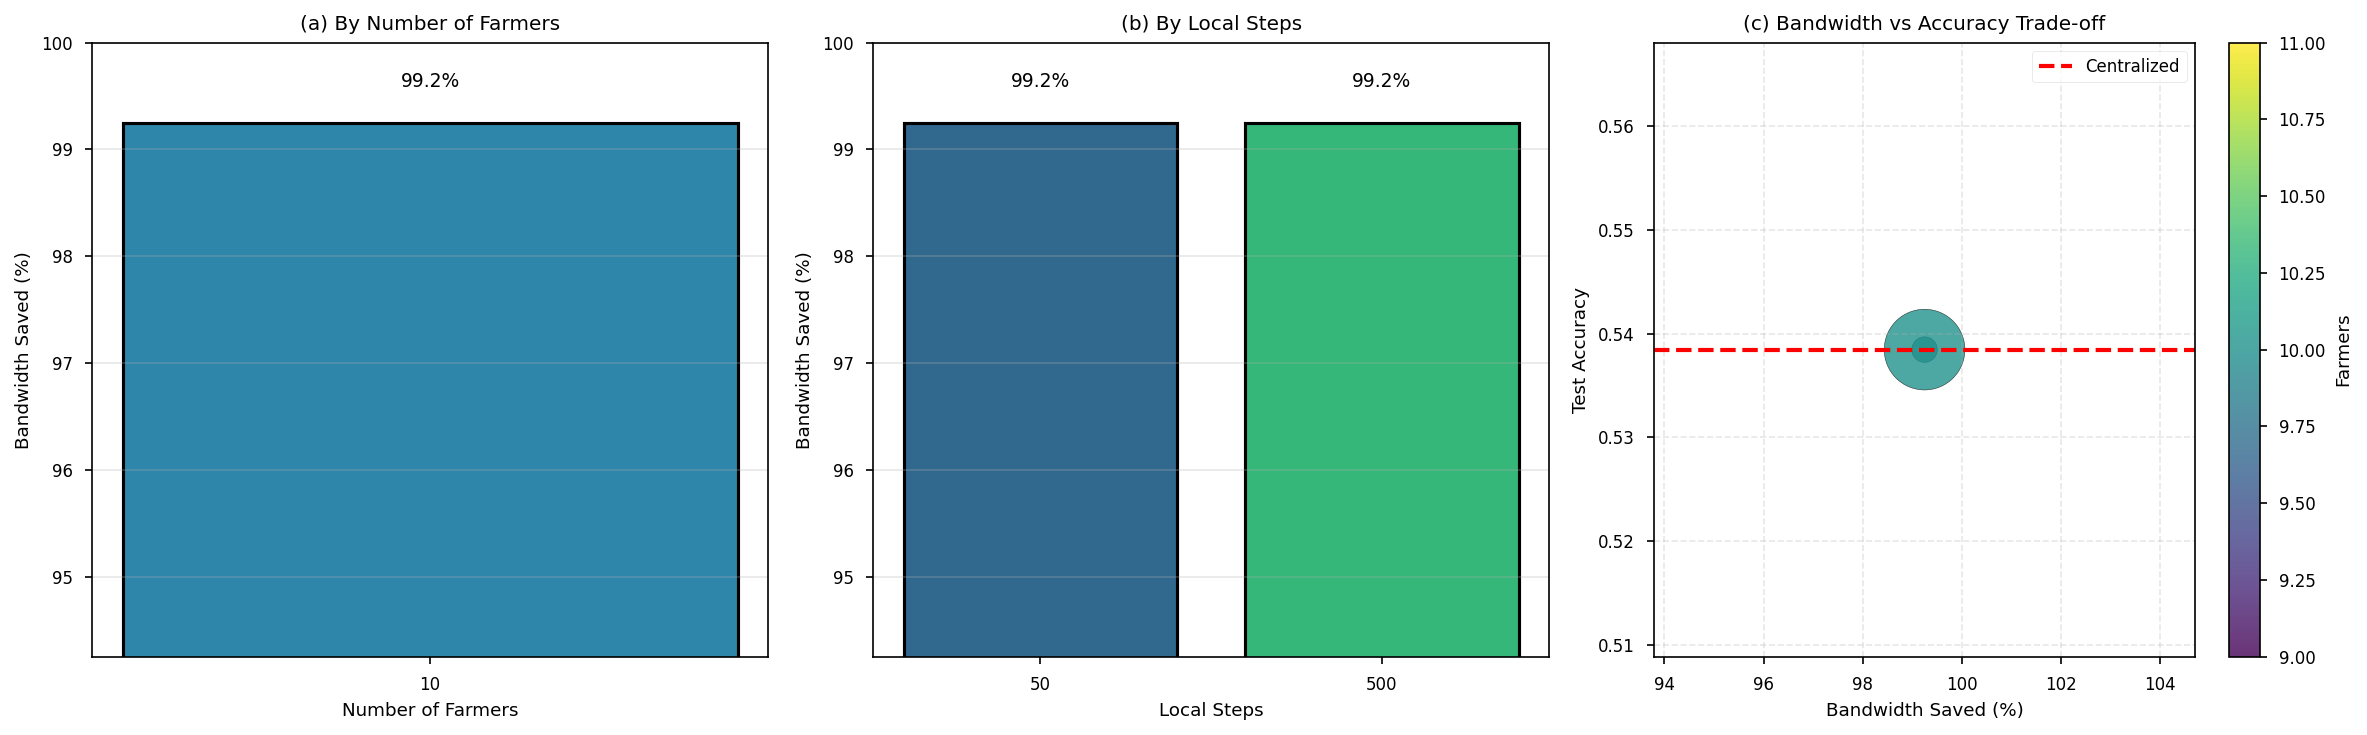


Average Bandwidth Savings: 99.25%
Range: 99.25% - 99.25%


In [33]:
# Bandwidth savings analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Bandwidth saved vs Number of Farmers
ax = axes[0]
bw_by_farmers = df.groupby('num_farmers')['avg_bandwidth_saved'].mean()
bars = ax.bar(bw_by_farmers.index.astype(str), bw_by_farmers.values, 
              color=['#2E86AB', '#A23B72', '#F18F01'], edgecolor='black', linewidth=1.5)
ax.set_xlabel('Number of Farmers')
ax.set_ylabel('Bandwidth Saved (%)')
ax.set_title('(a) By Number of Farmers')
ax.set_ylim([max(0, bw_by_farmers.min() - 5), 100])
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 2: Bandwidth saved vs Local Steps
ax = axes[1]
bw_by_steps = df.groupby('local_steps')['avg_bandwidth_saved'].mean()
bars = ax.bar(bw_by_steps.index.astype(str), bw_by_steps.values,
              color=sns.color_palette("viridis", len(bw_by_steps)), edgecolor='black', linewidth=1.5)
ax.set_xlabel('Local Steps')
ax.set_ylabel('Bandwidth Saved (%)')
ax.set_title('(b) By Local Steps')
ax.set_ylim([max(0, bw_by_steps.min() - 5), 100])
ax.grid(True, alpha=0.3, axis='y')
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 3: Trade-off scatter (bandwidth vs accuracy)
ax = axes[2]
if df['test_accuracy'].notna().any():
    scatter = ax.scatter(df['avg_bandwidth_saved'], df['test_accuracy'].fillna(0),
                         c=df['num_farmers'], s=df['local_steps'] * 3,
                         cmap='viridis', alpha=0.8, edgecolor='black')
    if baseline_data:
        ax.axhline(y=bt.get('accuracy', 0), color='red', linestyle='--', linewidth=2, label='Centralized')
    ax.set_xlabel('Bandwidth Saved (%)')
    ax.set_ylabel('Test Accuracy')
    ax.set_title('(c) Bandwidth vs Accuracy Trade-off')
    ax.grid(True, alpha=0.3, linestyle='--')
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Farmers')
    ax.legend()
else:
    ax.scatter(df['avg_bandwidth_saved'], df['loss_reduction_pct'],
               c=df['num_farmers'], s=df['local_steps'] * 3,
               cmap='viridis', alpha=0.8, edgecolor='black')
    ax.set_xlabel('Bandwidth Saved (%)')
    ax.set_ylabel('Loss Reduction (%)')
    ax.set_title('(c) Bandwidth vs Convergence Trade-off')
    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(plots_dir / 'bandwidth_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage Bandwidth Savings: {df['avg_bandwidth_saved'].mean():.2f}%")
print(f"Range: {df['avg_bandwidth_saved'].min():.2f}% - {df['avg_bandwidth_saved'].max():.2f}%")

## 4. Economic Impact Analysis

In [34]:
# Indonesian mobile data costs analysis
DATA_COST_PER_MB = 100  # IDR per MB (typical rural cost)
FULL_MODEL_SIZE_MB = 50  # Full model size in MB
avg_bw = df['avg_bandwidth_saved'].mean()
SHARD_SIZE_MB = FULL_MODEL_SIZE_MB * (100 - avg_bw) / 100

scenarios = [
    {'farmers': 50, 'rounds': 5, 'desc': 'Small cooperative'},
    {'farmers': 100, 'rounds': 10, 'desc': 'Medium cooperative'},
    {'farmers': 500, 'rounds': 10, 'desc': 'Large network'},
]

print("Economic Impact Analysis for Indonesian Farmers")
print("=" * 60)
print(f"Average Bandwidth Savings: {avg_bw:.2f}%")
print(f"Full Model Size: {FULL_MODEL_SIZE_MB} MB | Shard Size: {SHARD_SIZE_MB:.2f} MB")
print("=" * 60)

for s in scenarios:
    trad_cost = FULL_MODEL_SIZE_MB * DATA_COST_PER_MB * s['rounds']
    diloco_cost = SHARD_SIZE_MB * DATA_COST_PER_MB * s['rounds']
    savings_per = trad_cost - diloco_cost
    total_savings = savings_per * s['farmers']
    
    print(f"\n{s['desc']}: {s['farmers']} farmers, {s['rounds']} rounds")
    print(f"  Per Farmer Savings: IDR {savings_per:,.0f} (${savings_per/15000:.2f})")
    print(f"  Total Savings: IDR {total_savings:,.0f} (${total_savings/15000:.2f})")

Economic Impact Analysis for Indonesian Farmers
Average Bandwidth Savings: 99.25%
Full Model Size: 50 MB | Shard Size: 0.38 MB

Small cooperative: 50 farmers, 5 rounds
  Per Farmer Savings: IDR 24,812 ($1.65)
  Total Savings: IDR 1,240,615 ($82.71)

Medium cooperative: 100 farmers, 10 rounds
  Per Farmer Savings: IDR 49,625 ($3.31)
  Total Savings: IDR 4,962,461 ($330.83)

Large network: 500 farmers, 10 rounds
  Per Farmer Savings: IDR 49,625 ($3.31)
  Total Savings: IDR 24,812,306 ($1654.15)


## 5. Paper-Ready Heatmaps & Comprehensive Figure

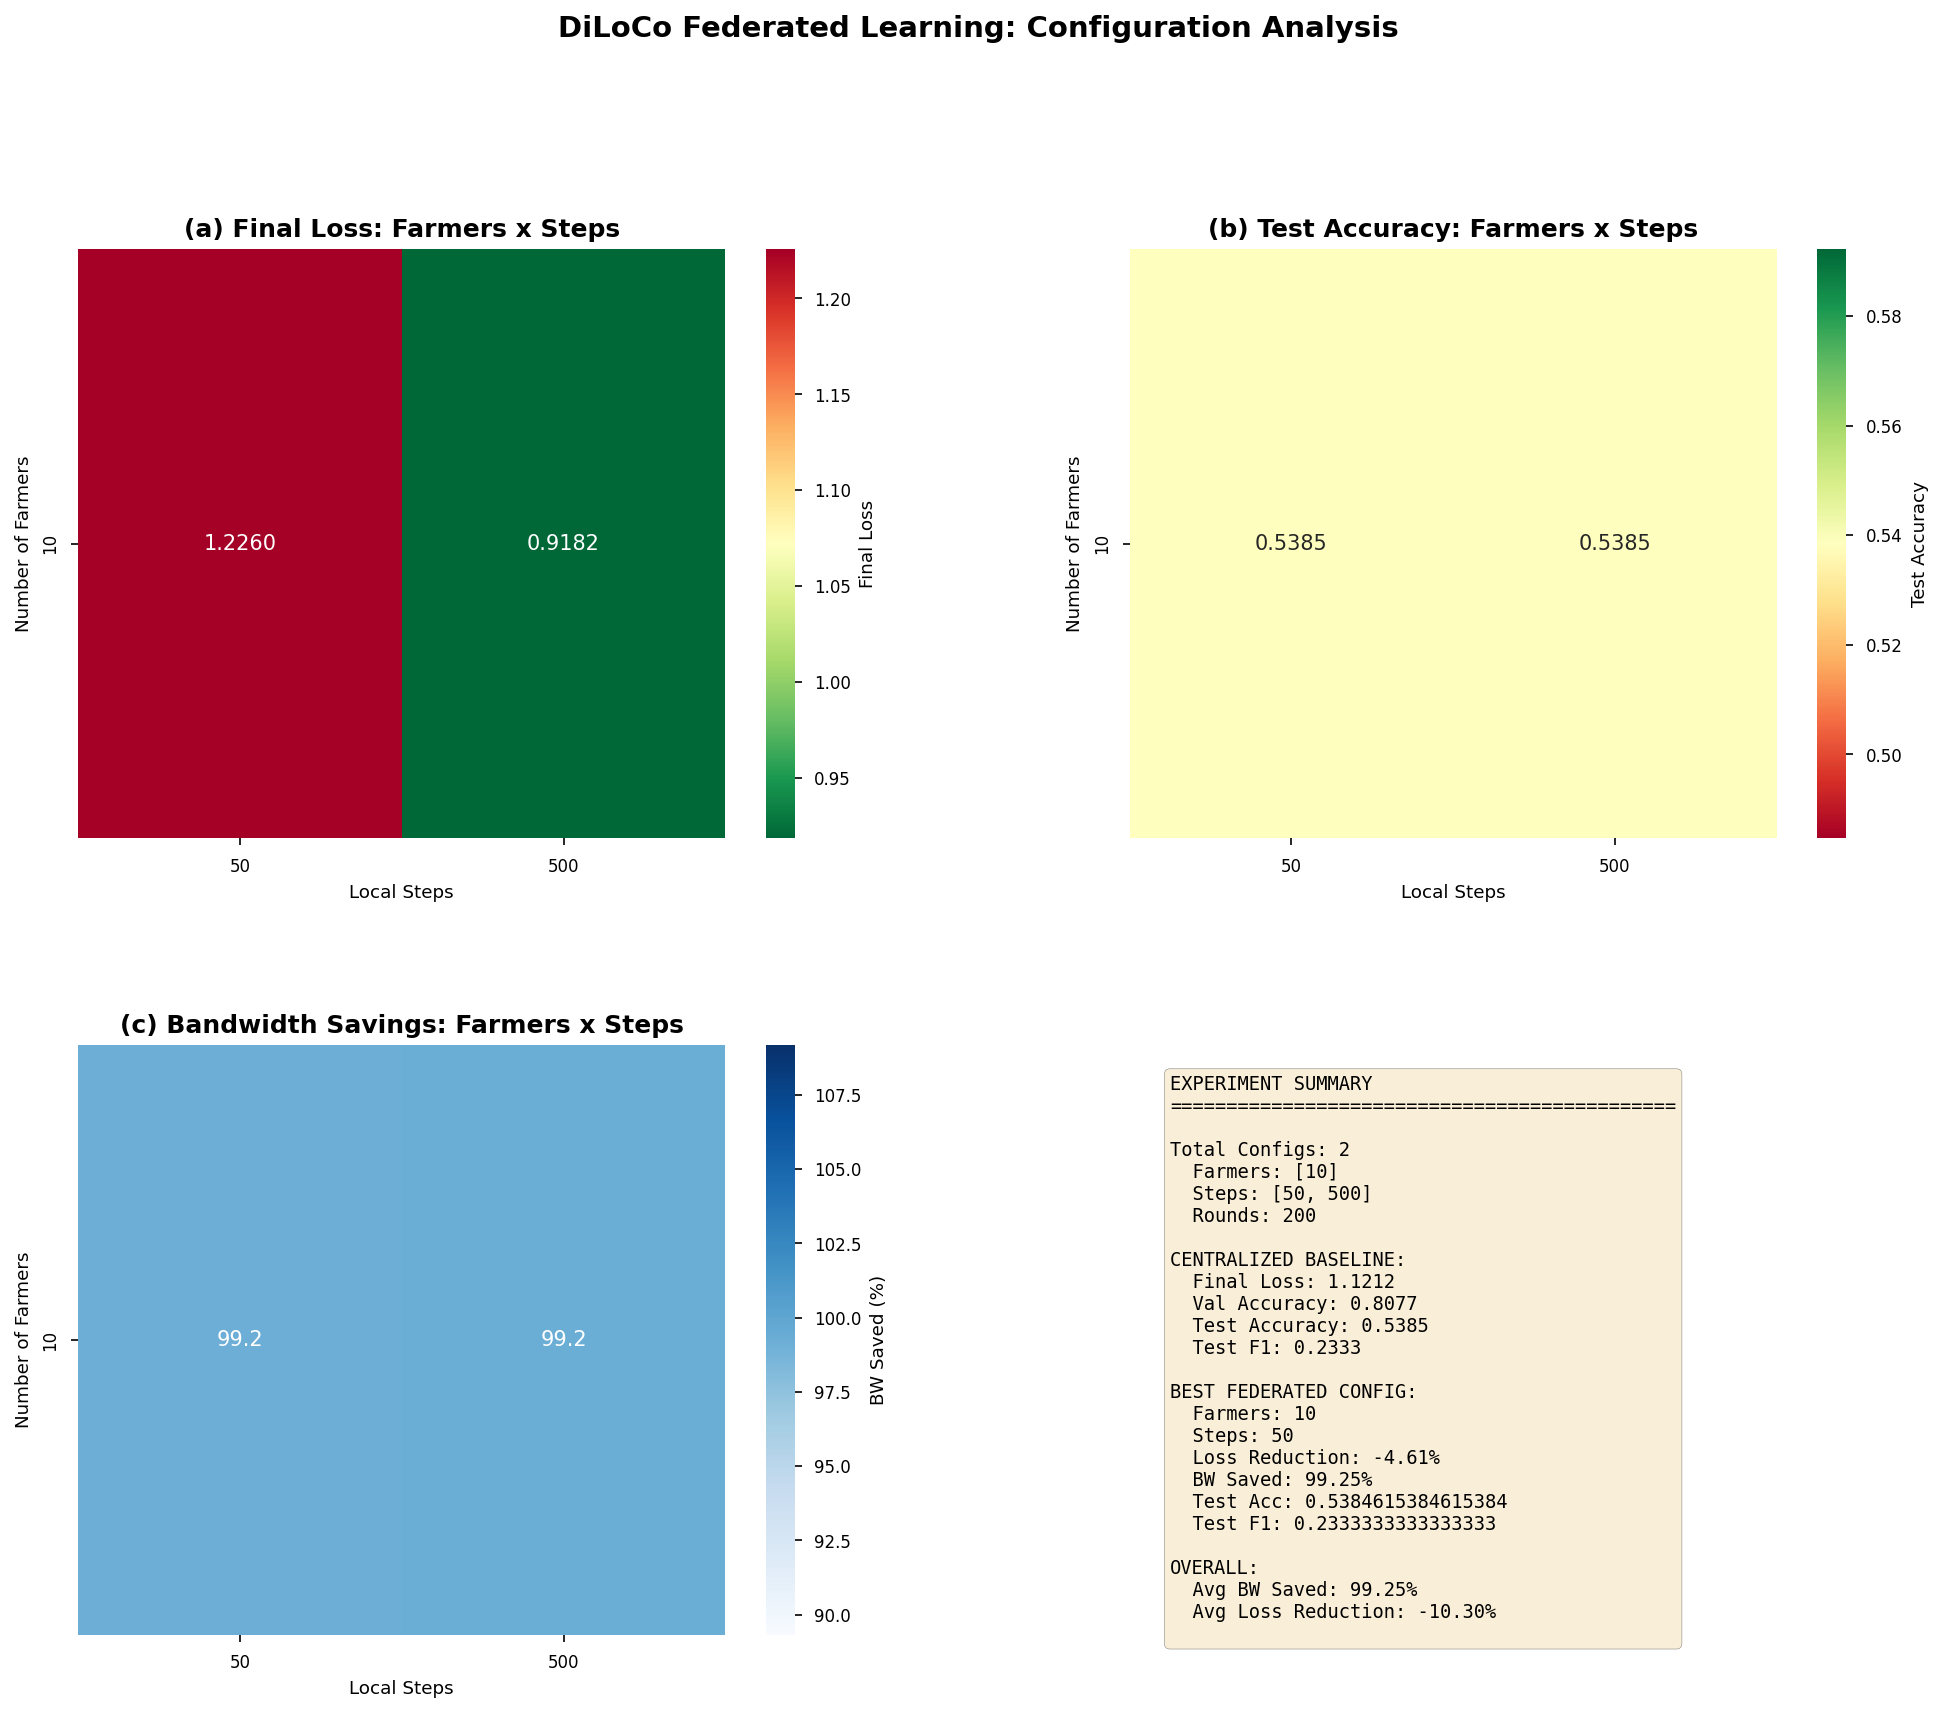

Comprehensive paper figure saved!


In [35]:
# Comprehensive paper figure with heatmaps
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.3)

# (a) Heatmap: Final Loss
ax1 = fig.add_subplot(gs[0, 0])
pivot_loss = df.pivot_table(values='final_loss', index='num_farmers', columns='local_steps', aggfunc='mean')
sns.heatmap(pivot_loss, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax1, cbar_kws={'label': 'Final Loss'})
ax1.set_title('(a) Final Loss: Farmers x Steps', fontsize=12, fontweight='bold')
ax1.set_xlabel('Local Steps')
ax1.set_ylabel('Number of Farmers')

# (b) Heatmap: Test Accuracy (or loss reduction if no accuracy)
ax2 = fig.add_subplot(gs[0, 1])
if df['test_accuracy'].notna().any():
    pivot_acc = df.pivot_table(values='test_accuracy', index='num_farmers', columns='local_steps', aggfunc='mean')
    sns.heatmap(pivot_acc, annot=True, fmt='.4f', cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'Test Accuracy'})
    ax2.set_title('(b) Test Accuracy: Farmers x Steps', fontsize=12, fontweight='bold')
else:
    pivot_red = df.pivot_table(values='loss_reduction_pct', index='num_farmers', columns='local_steps', aggfunc='mean')
    sns.heatmap(pivot_red, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'Loss Reduction (%)'})
    ax2.set_title('(b) Loss Reduction %: Farmers x Steps', fontsize=12, fontweight='bold')
ax2.set_xlabel('Local Steps')
ax2.set_ylabel('Number of Farmers')

# (c) Heatmap: Bandwidth Saved
ax3 = fig.add_subplot(gs[1, 0])
pivot_bw = df.pivot_table(values='avg_bandwidth_saved', index='num_farmers', columns='local_steps', aggfunc='mean')
sns.heatmap(pivot_bw, annot=True, fmt='.1f', cmap='Blues', ax=ax3, cbar_kws={'label': 'BW Saved (%)'})
ax3.set_title('(c) Bandwidth Savings: Farmers x Steps', fontsize=12, fontweight='bold')
ax3.set_xlabel('Local Steps')
ax3.set_ylabel('Number of Farmers')

# (d) Summary text
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

best_config = df.loc[df['loss_reduction_pct'].idxmax()]
central_info = ""
if baseline_data:
    central_info = f"""
CENTRALIZED BASELINE:
  Final Loss: {bs['final_loss']:.4f}
  Val Accuracy: {bs.get('final_val_accuracy', 0):.4f}
  Test Accuracy: {bt.get('accuracy', 0):.4f}
  Test F1: {bt.get('f1_macro', 0):.4f}
"""

summary_text = f"""EXPERIMENT SUMMARY
{'='*45}

Total Configs: {len(df)}
  Farmers: {sorted(df['num_farmers'].unique().astype(int).tolist())}
  Steps: {sorted(df['local_steps'].unique().astype(int).tolist())}
  Rounds: {df['num_rounds'].iloc[0]}
{central_info}
BEST FEDERATED CONFIG:
  Farmers: {int(best_config['num_farmers'])}
  Steps: {int(best_config['local_steps'])}
  Loss Reduction: {best_config['loss_reduction_pct']:.2f}%
  BW Saved: {best_config['avg_bandwidth_saved']:.2f}%
  Test Acc: {best_config.get('test_accuracy', 'N/A')}
  Test F1: {best_config.get('test_f1', 'N/A')}

OVERALL:
  Avg BW Saved: {df['avg_bandwidth_saved'].mean():.2f}%
  Avg Loss Reduction: {df['loss_reduction_pct'].mean():.2f}%
"""
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('DiLoCo Federated Learning: Configuration Analysis', 
             fontsize=14, fontweight='bold', y=1.01)
plt.savefig(plots_dir / 'paper_figure_comprehensive.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("Comprehensive paper figure saved!")

## 6. Export LaTeX Tables for Paper

In [36]:
# Generate LaTeX tables for the paper
def latex_file(title, content, filename):
    return f"""% {title}
% Generated automatically by TaniFi analysis notebook

\\documentclass{{article}}
\\usepackage{{booktabs}}
\\usepackage[margin=1in]{{geometry}}
\\begin{{document}}

% === COPY START ===

{content}

% === COPY END ===

\\end{{document}}
"""

# Table 1: Full results with accuracy/F1
cols = ['num_farmers', 'local_steps', 'final_loss', 'loss_reduction_pct', 
        'avg_bandwidth_saved']
acc_cols = []
if df['test_accuracy'].notna().any():
    cols += ['test_accuracy', 'test_f1']
    acc_cols = ['test_accuracy', 'test_f1']

df_table = df[cols].copy()
df_table.columns = ['Farmers', 'Steps', 'Final Loss', 'Loss Red. (%)', 'BW Saved (%)'] + \
                   (['Test Acc', 'Test F1'] if acc_cols else [])

best_idx = df_table['Loss Red. (%)'].idxmax()

# Build LaTeX rows
num_data_cols = len(df_table.columns)
col_spec = 'r' * num_data_cols
header = ' & '.join(df_table.columns) + ' \\\\'

rows = []
for i, row in df_table.iterrows():
    parts = []
    for col in df_table.columns:
        val = row[col]
        if col in ['Farmers', 'Steps']:
            parts.append(f"{int(val)}")
        elif col == 'Loss Red. (%)':
            s = f"{val:.2f}"
            if i == best_idx:
                s = f"\\textbf{{{s}}}"
            parts.append(s)
        elif col in ['Final Loss']:
            parts.append(f"{val:.4f}")
        elif col in ['Test Acc', 'Test F1']:
            parts.append(f"{val:.4f}" if pd.notna(val) else "N/A")
        else:
            parts.append(f"{val:.2f}")
    rows.append(' & '.join(parts) + ' \\\\')

# Group rows by farmers with midrules
farmers_list = sorted(df['num_farmers'].unique())
grouped_rows = []
for fi, f in enumerate(farmers_list):
    mask = df_table['Farmers'].astype(int) == int(f)
    group = [r for r, m in zip(rows, mask) if m]
    grouped_rows.extend(group)
    if fi < len(farmers_list) - 1:
        grouped_rows.append('\\midrule')

full_table = f"""\\begin{{table}}[h]
\\centering
\\caption{{DiLoCo Experiment Results ({len(df)} Configurations)}}
\\label{{tab:full_results}}
\\begin{{tabular}}{{{col_spec}}}
\\toprule
{header}
\\midrule
{chr(10).join(grouped_rows)}
\\bottomrule
\\end{{tabular}}
\\end{{table}}"""

with open(tables_dir / 'full_results.tex', 'w') as f:
    f.write(latex_file('Full Results', full_table, 'full_results.tex'))

# Table 2: Centralized vs Federated comparison
if baseline_data:
    best_fed = df.loc[df['loss_reduction_pct'].idxmax()]
    comp_table = f"""\\begin{{table}}[h]
\\centering
\\caption{{Centralized vs Federated (DiLoCo) Training Comparison}}
\\label{{tab:centralized_vs_federated}}
\\begin{{tabular}}{{lrr}}
\\toprule
Metric & Centralized & Best Federated \\\\
\\midrule
Final Train Loss & {bs['final_loss']:.4f} & {best_fed['final_loss']:.4f} \\\\
Val Accuracy & {bs.get('final_val_accuracy', 0):.4f} & {best_fed.get('final_val_accuracy', 0):.4f} \\\\
Val F1 (macro) & {bs.get('final_val_f1', 0):.4f} & {best_fed.get('final_val_f1', 0):.4f} \\\\
Test Accuracy & {bt.get('accuracy', 0):.4f} & {best_fed.get('test_accuracy', 0):.4f} \\\\
Test F1 (macro) & {bt.get('f1_macro', 0):.4f} & {best_fed.get('test_f1', 0):.4f} \\\\
Bandwidth Saved (\\%) & 0.00 & {best_fed['avg_bandwidth_saved']:.2f} \\\\
\\bottomrule
\\end{{tabular}}
\\end{{table}}"""
    
    with open(tables_dir / 'centralized_vs_federated.tex', 'w') as f:
        f.write(latex_file('Centralized vs Federated', comp_table, 'centralized_vs_federated.tex'))

# Table 3: Summary by farmers
summary_farmers = df.groupby('num_farmers').agg({
    'final_loss': ['mean', 'std', 'min'],
    'loss_reduction_pct': ['mean', 'max'],
    'avg_bandwidth_saved': 'mean'
}).round(4)
summary_farmers.columns = ['Loss Mean', 'Loss Std', 'Loss Min', 'Red Mean', 'Red Max', 'BW Saved']

farmers_rows = []
for farmers, row in summary_farmers.iterrows():
    std_val = f"{row['Loss Std']:.4f}" if pd.notna(row['Loss Std']) else "---"
    farmers_rows.append(f"{int(farmers)} & {row['Loss Mean']:.4f} & {std_val} & {row['Loss Min']:.4f} & {row['Red Mean']:.2f} & {row['Red Max']:.2f} & {row['BW Saved']:.2f} \\\\")

farmers_table = f"""\\begin{{table}}[h]
\\centering
\\caption{{Results Summary by Number of Farmers}}
\\label{{tab:summary_farmers}}
\\begin{{tabular}}{{rrrrrrr}}
\\toprule
Farmers & Loss (mean) & Loss (std) & Loss (min) & Red. (mean) & Red. (max) & BW Saved (\\%) \\\\
\\midrule
{chr(10).join(farmers_rows)}
\\bottomrule
\\end{{tabular}}
\\end{{table}}"""

with open(tables_dir / 'summary_by_farmers.tex', 'w') as f:
    f.write(latex_file('Summary by Farmers', farmers_table, 'summary_by_farmers.tex'))

# Table 4: Summary by steps
summary_steps = df.groupby('local_steps').agg({
    'final_loss': ['mean', 'std', 'min'],
    'loss_reduction_pct': ['mean', 'max'],
    'avg_bandwidth_saved': 'mean'
}).round(4)
summary_steps.columns = ['Loss Mean', 'Loss Std', 'Loss Min', 'Red Mean', 'Red Max', 'BW Saved']

steps_rows = []
for steps, row in summary_steps.iterrows():
    std_val = f"{row['Loss Std']:.4f}" if pd.notna(row['Loss Std']) else "---"
    steps_rows.append(f"{int(steps)} & {row['Loss Mean']:.4f} & {std_val} & {row['Loss Min']:.4f} & {row['Red Mean']:.2f} & {row['Red Max']:.2f} & {row['BW Saved']:.2f} \\\\")

steps_table = f"""\\begin{{table}}[h]
\\centering
\\caption{{Results Summary by Local Steps}}
\\label{{tab:summary_steps}}
\\begin{{tabular}}{{rrrrrrr}}
\\toprule
Steps & Loss (mean) & Loss (std) & Loss (min) & Red. (mean) & Red. (max) & BW Saved (\\%) \\\\
\\midrule
{chr(10).join(steps_rows)}
\\bottomrule
\\end{{tabular}}
\\end{{table}}"""

with open(tables_dir / 'summary_by_steps.tex', 'w') as f:
    f.write(latex_file('Summary by Steps', steps_table, 'summary_by_steps.tex'))

# Table 5: Overall summary
overall_table = f"""\\begin{{table}}[h]
\\centering
\\caption{{DiLoCo Simulation Results - Overall Summary}}
\\label{{tab:results_summary}}
\\begin{{tabular}}{{ll}}
\\toprule
Metric & Value \\\\
\\midrule
Total Configurations & {len(df)} \\\\
Farmers Tested & {', '.join(str(int(x)) for x in sorted(df['num_farmers'].unique()))} \\\\
Local Steps Tested & {', '.join(str(int(x)) for x in sorted(df['local_steps'].unique()))} \\\\
Federated Rounds & {df['num_rounds'].iloc[0]} \\\\
\\midrule
Avg Bandwidth Savings (\\%) & {df['avg_bandwidth_saved'].mean():.2f} \\\\
Avg Loss Reduction (\\%) & {df['loss_reduction_pct'].mean():.2f} \\\\
Best Loss Reduction (\\%) & \\textbf{{{best_config['loss_reduction_pct']:.2f}}} ({int(best_config['num_farmers'])}f, {int(best_config['local_steps'])}s) \\\\
\\midrule
Best Final Loss & {df['final_loss'].min():.4f} \\\\
Worst Final Loss & {df['final_loss'].max():.4f} \\\\
\\bottomrule
\\end{{tabular}}
\\end{{table}}"""

with open(tables_dir / 'results_summary.tex', 'w') as f:
    f.write(latex_file('Overall Summary', overall_table, 'results_summary.tex'))

print(f"LaTeX tables saved to: {tables_dir}")
for f in sorted(tables_dir.glob('*.tex')):
    print(f"  - {f.name}")

LaTeX tables saved to: ../experiments/results/tables
  - centralized_vs_federated.tex
  - full_results.tex
  - results_summary.tex
  - summary_by_farmers.tex
  - summary_by_steps.tex
